In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

In [2]:
df = pd.read_csv(r"insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Visualize

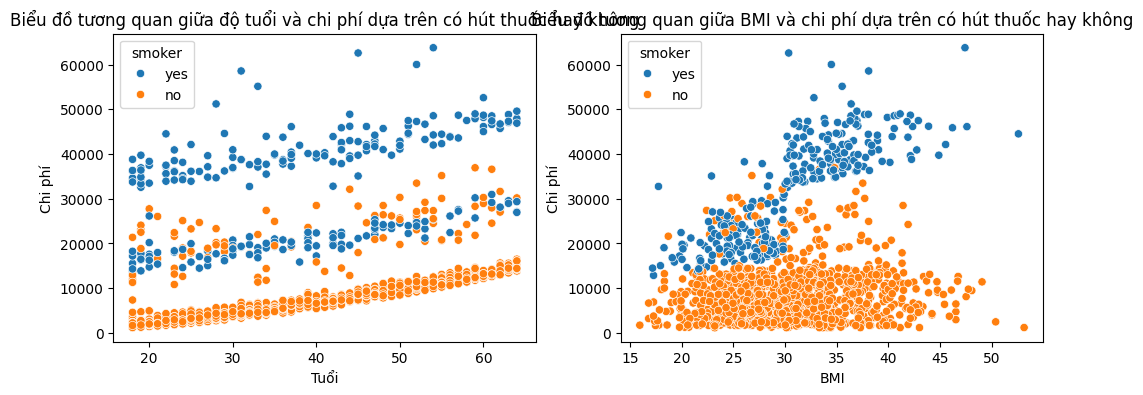

In [3]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
sns.scatterplot(data = df, x = "age", y = "charges", hue = "smoker", ax = ax[0])
ax[0].set(title = "Biểu đồ tương quan giữa độ tuổi và chi phí dựa trên có hút thuốc hay không",
       xlabel = "Tuổi",
       ylabel = "Chi phí")

sns.scatterplot(data = df, x = "bmi", y = "charges", hue = "smoker", ax = ax[1])
ax[1].set(title = "Biểu đồ tương quan giữa BMI và chi phí dựa trên có hút thuốc hay không",
       xlabel = "BMI",
       ylabel = "Chi phí")
plt.show()

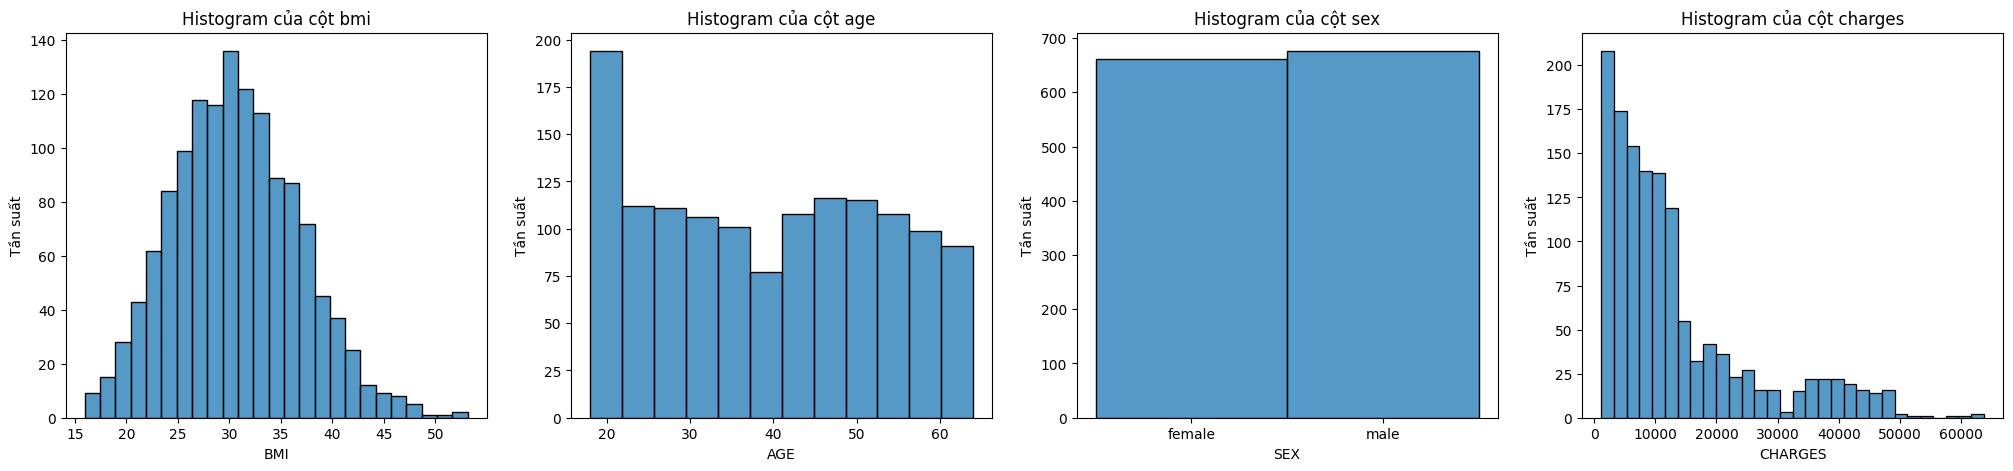

In [4]:
cols = ["bmi", "age", "sex", "charges"]
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
for i, col in enumerate(cols):
    sns.histplot(x = col, data = df, ax = ax[i])
    ax[i].set(title = f"Histogram của cột {col}",
             xlabel = col.upper(),
             ylabel = "Tần suất")
plt.show()

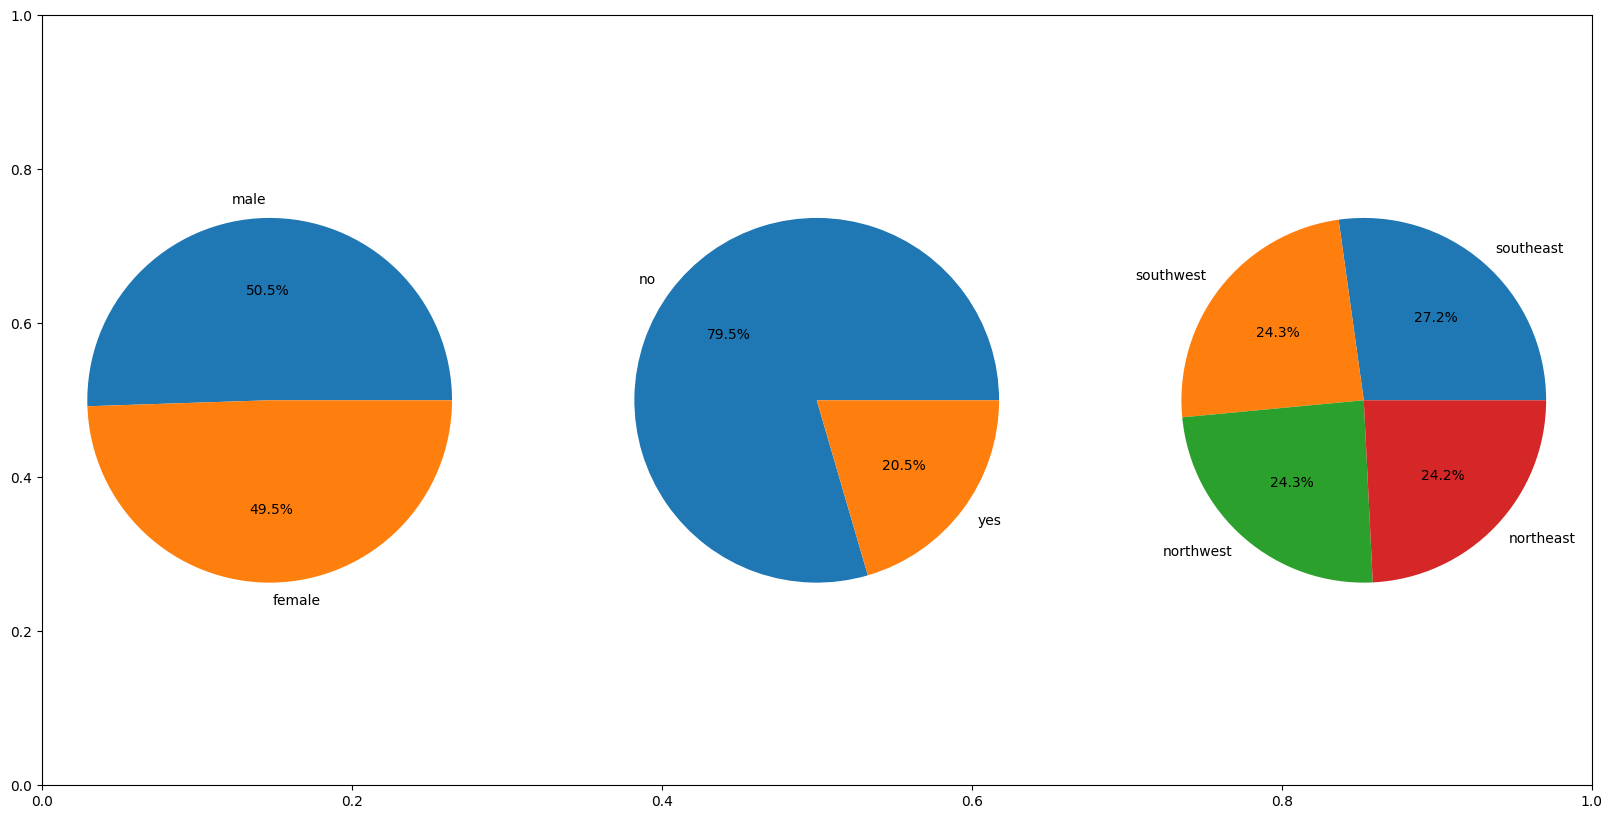

In [5]:
features = ['sex', 'smoker', 'region']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)

    x = df[col].value_counts()
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')

plt.show()

C:\Users\ntlua\AppData\Local\Temp\ipykernel_20896\1600189664.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["bmi"], df["age"]], labels=["bmi", "age"])


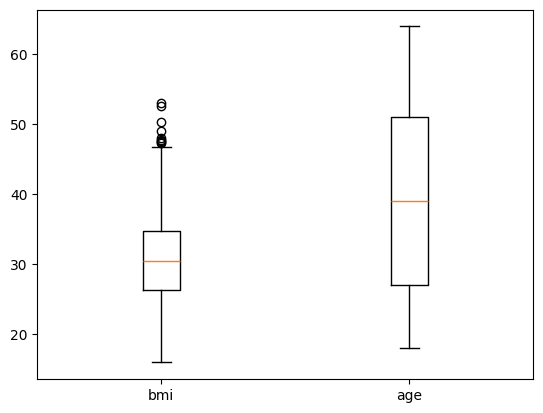

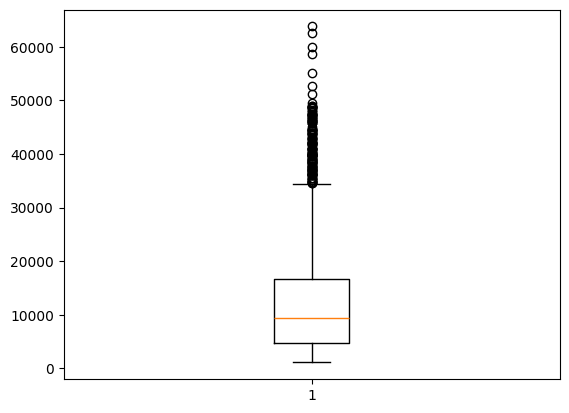

In [6]:
plt.boxplot([df["bmi"], df["age"]], labels=["bmi", "age"])
plt.show()

plt.boxplot(df["charges"])
plt.show()

### Clean Data

In [7]:
def upperAndlower(col):
    Q1 = np.percentile(col, 25)
    Q3 = np.percentile(col, 75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return upper, lower
df_clean = df.copy()
cols = ["age", "bmi", "children"]
for col in cols:
    upper, lower = upperAndlower(df[col])
    print(f"Cột {col} có upper = {upper} và lower = {lower}")
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
print(len(df))
print(len(df_clean))

Cột age có upper = 87.0 và lower = -9.0
Cột bmi có upper = 47.290000000000006 và lower = 13.7
Cột children có upper = 5.0 và lower = -3.0
1338
1329


C:\Users\ntlua\AppData\Local\Temp\ipykernel_20896\3035225666.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_clean["bmi"], df_clean["age"]], labels=["bmi", "age"])


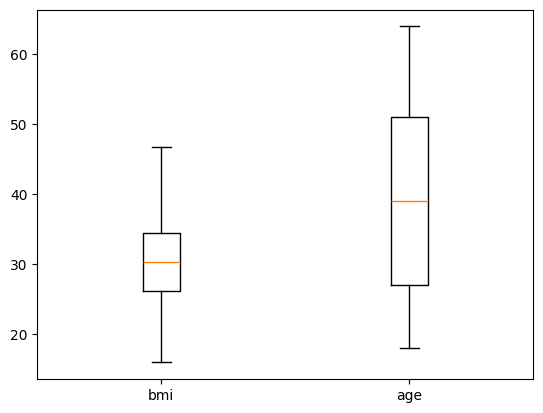

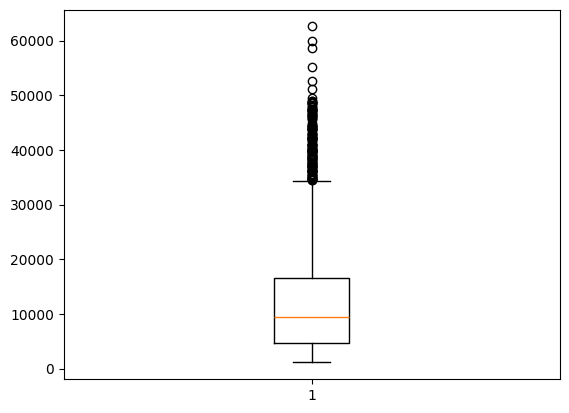

In [8]:
plt.boxplot([df_clean["bmi"], df_clean["age"]], labels=["bmi", "age"])
plt.show()

plt.boxplot(df_clean["charges"])
plt.show()

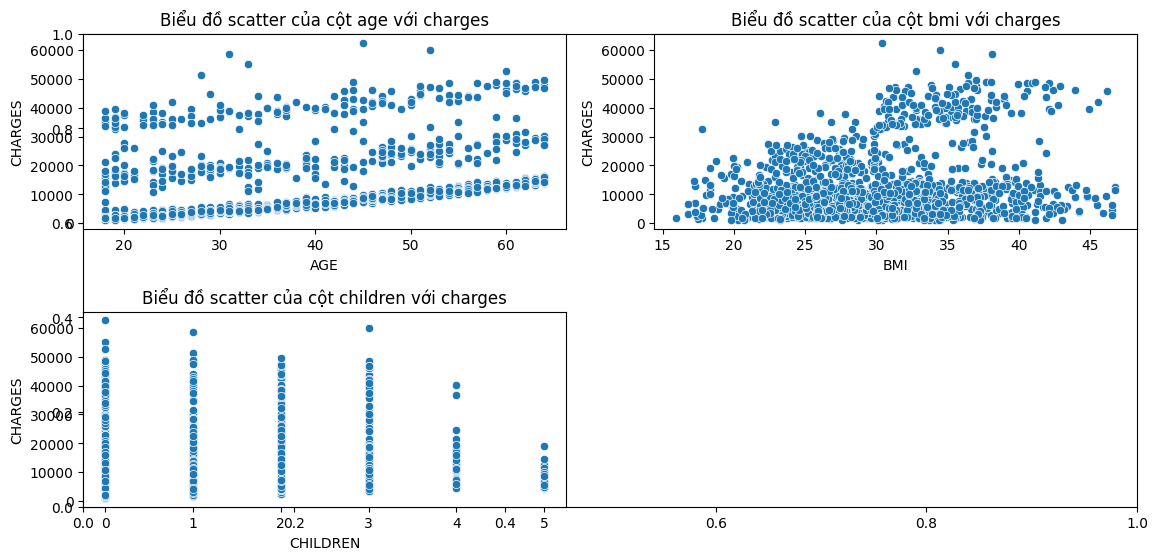

In [9]:
plt.subplots(figsize = (12, 6))
for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data = df_clean, x = col, y = "charges")
    plt.title(f"Biểu đồ scatter của cột {col} với charges")
    plt.xlabel(col.upper())
    plt.ylabel("CHARGES")
plt.tight_layout()
plt.show()

In [10]:
df_clean["sex"] = df_clean["sex"].map({"male": 0, "female": 1})
df_clean["smoker"] = df_clean["smoker"].map({"yes": 1, "no": 0})
df_clean['region']=df_clean['region'].map({'northwest':0, 'northeast':1,'southeast':2,'southwest':3})

In [11]:
df_xgb = df_clean.copy()
df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,0,21984.47061
4,32,0,28.880,0,0,0,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0,10600.54830
1334,18,1,31.920,0,0,1,2205.98080
1335,18,1,36.850,0,0,2,1629.83350
1336,21,1,25.800,0,0,3,2007.94500


In [12]:
cols.append("charges")
scaler = StandardScaler()
df_clean[cols] = scaler.fit_transform(df_clean[cols])
df_clean

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,1,-0.445670,-0.907940,1,3,0.306235
1,-1.509976,0,0.546267,-0.079764,0,2,-0.957813
2,-0.797855,0,0.416149,1.576587,0,2,-0.730682
3,-0.441794,0,-1.323542,-0.907940,0,0,0.731455
4,-0.513006,0,-0.280065,-0.907940,0,0,-0.779262
...,...,...,...,...,...,...,...
1333,0.768813,0,0.073111,1.576587,0,0,-0.217781
1334,-1.509976,1,0.233646,-0.907940,0,1,-0.917753
1335,-1.509976,1,1.066737,-0.907940,0,2,-0.965794
1336,-1.296340,1,-0.800536,-0.907940,0,3,-0.934266


In [13]:
X = df_clean.drop(["charges"], axis = 1)
Y = df_clean["charges"]

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Linear Regression

In [15]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)
print(r2_score(Y_test, y_pred))

0.7674028095432548


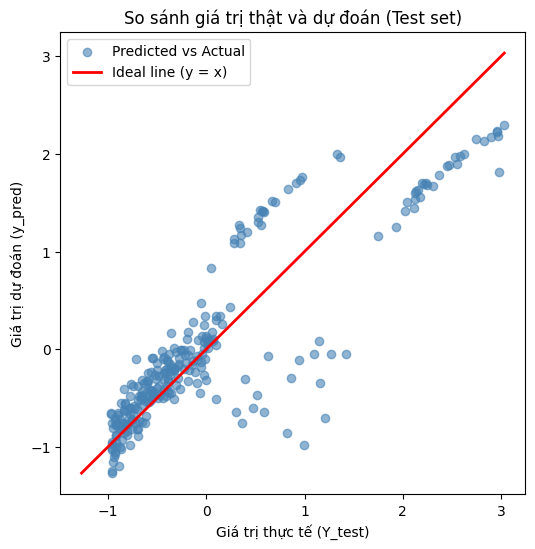

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred, color="steelblue", alpha=0.6, label="Predicted vs Actual")

# Vẽ đường lý tưởng y = x
min_val = min(Y_test.min(), y_pred.min())
max_val = max(Y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2, label="Ideal line (y = x)")

plt.xlabel("Giá trị thực tế (Y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.legend()
plt.title("So sánh giá trị thật và dự đoán (Test set)")
plt.show()

### Polynomial Regression

In [17]:
poly = PolynomialFeatures(3)
X__train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr2 = LinearRegression()
lr2.fit(X__train_poly, Y_train)
y_pred2 = lr2.predict(X_test_poly)
print(r2_score(Y_test, y_pred2))

0.8559323899691273


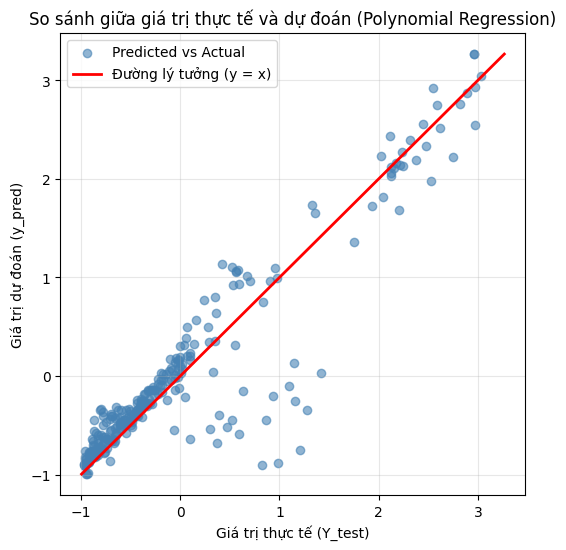

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred2, color="steelblue", alpha=0.6, label="Predicted vs Actual")

# Vẽ đường y = x (đường lý tưởng nếu dự đoán hoàn hảo)
min_val = min(Y_test.min(), y_pred2.min())
max_val = max(Y_test.max(), y_pred2.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2, label="Đường lý tưởng (y = x)")

# Trang trí biểu đồ
plt.xlabel("Giá trị thực tế (Y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.title("So sánh giữa giá trị thực tế và dự đoán (Polynomial Regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### XG Boost

In [36]:
df_xgb

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,0,21984.47061
4,32,0,28.880,0,0,0,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0,10600.54830
1334,18,1,31.920,0,0,1,2205.98080
1335,18,1,36.850,0,0,2,1629.83350
1336,21,1,25.800,0,0,3,2007.94500


In [19]:
X_xgb = df_xgb.drop("charges", axis=1)
Y_xgb = df_xgb["charges"]

In [20]:
X_xgb_train, X_xgb_test, Y_xgb_train, Y_xgb_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=123)

In [21]:
param = {'max_depth': [3,4,5,6,7,8,9,10],
        'n_estimators': [10,20,30,40,50,60,70,80,90,100],
        'learning_rate': [0.001, 0.01, 0.1, 0.005, 0.05, 0.5, 1],
        'gamma': [0, 0.15, 0.3, 0.5, 1]}
estimator = xgb.XGBRegressor()
grid = GridSearchCV(estimator=estimator, param_grid=param, scoring='r2', cv=10)
grid.fit(X_xgb_train, Y_xgb_train)
print(grid.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [32]:
params = {'objective': 'reg:linear',
          'max_depth': 3,
          'n_estimators': 50,
          'gamma': 0,
          'learning_rate': 0.1
        }
model = xgb.XGBRegressor(**params)
model.fit(X_xgb_train, Y_xgb_train)

C:\Users\ntlua\anaconda3\envs\tf_gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [22:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [34]:
print(model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)


In [33]:
y_pred_test = model.predict(X_xgb_test)
y_pred_train = model.predict(X_xgb_train)
print("R2 test:", r2_score(Y_xgb_test, y_pred_test))
print("R2 train:", r2_score(Y_xgb_train, y_pred_train))

R2 test: 0.8527349843405376
R2 train: 0.886113598067684
